# v5 evaluation

In [1]:
import os
import sys
import random

from pathlib import Path
from torch.utils.data import DataLoader
from IPython.display import SVG, display

### 0. Add packages to python path

In [2]:
b_paths = [os.path.abspath(os.path.join('..', '..')), os.path.abspath(os.path.join('..')), os.path.abspath(os.path.join('..', 'scripts'))]
for b_path in b_paths:
    if b_path not in sys.path:
        sys.path.append(b_path)

BASE_DIR = Path(os.getcwd()).parent.parent.resolve()
%cd $BASE_DIR

I:\My Drive\master_thesis_experiments\stroke2postfix-transformer


## 1. Load model and test set

In [4]:
from models.scripts.generate_arithmetic_sequences import SequenceGenerator
from models.scripts.transformer.ExprTree_model import load_json_hypeparameters, pad_collate_fn, model_builder
from models.scripts.transformer.utils import preprocess_dataset, seed_all, build_vocab, tensor_to_word, strokes_to_svg
from models.scripts.utils import Levenshtein_Normalized_distance

In [5]:
VERSION = "v5"
SEED = 2021
BATCH_SIZE = 256
seed_all(SEED)

In [6]:
hp = load_json_hypeparameters(VERSION)
VOCAB = dict(hp['vocab'])
VOCAB = build_vocab(a for a in VOCAB.keys() if a not in ['<pad>', '<bos>', '<eos>', '<unk>'])
hp['vocab']=VOCAB
N_TOKENS = len(VOCAB)
PAD_IDX = VOCAB['<pad>']
BOS_IDX = VOCAB['<bos>']
EOS_IDX = VOCAB['<eos>']

print(f"Number of Tokens: {N_TOKENS}\n")
print({VOCAB.itos[i]: i for i in range(N_TOKENS)}) # Token order

Number of Tokens: 22

{'<unk>': 0, '<pad>': 1, '<bos>': 2, '<eos>': 3, '(': 4, ')': 5, '*': 6, '+': 7, '-': 8, '.': 9, '/': 10, '0': 11, '1': 12, '2': 13, '3': 14, '4': 15, '5': 16, '6': 17, '7': 18, '8': 19, '9': 20, '=': 21}


In [7]:
d_gen = SequenceGenerator(
        vocab = VOCAB,
        allow_brackets = True,
        save_mode = 'postfix',
        total_expressions = 120 * 1000)\

raw_test_set = d_gen.generate_from_cache(mode='test')

pre_test = preprocess_dataset(raw_test_set, VOCAB,  os.path.join(d_gen.fname, "test.pt"))

test_set = DataLoader(pre_test, batch_size=BATCH_SIZE, shuffle=True, collate_fn=pad_collate_fn)

Using cached dataset file in cache\expressions_cache\expressions_120k_pb.h5
cache\preprocessed_datasets\expressions_120k_pb\test.pt
Using cached processed dataset


In [8]:
model = model_builder(name=VERSION, **hp)
model.load_best_version()

ModuleNotFoundError: No module named 'scripts.transformer'

## 2. Test on a single expression (0 and 1 required)

In [10]:
test_set_iter = iter(test_set)
x_pred, y_pred = next(test_set_iter)

x_pred = x_pred.to(model.device)
y_pred = y_pred.to(model.device)

I:\My Drive\master_thesis_experiments\stroke2postfix-transformer\models\scripts\transformer\ExprTree_model.py:128: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  yy.append(torch.tensor(y_, dtype=torch.int64))


Index: 206 



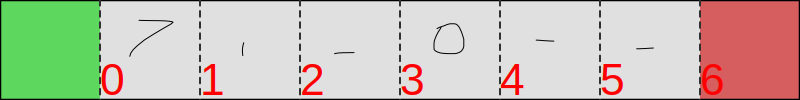

Ground truth =>  [2, 18, 11, 7, 21, 3] 

Ground Truth: <bos>70+=<eos><pad><pad><pad><pad><pad><pad><pad><pad> (len=4)
- Prediction: 5<eos> (len=0)
Normalized Levenshtein distance is: 0.8888888888888888


In [11]:
ind = random.choice(range(0, y_pred.shape[0]))
print("Index:", ind, "\n")

svg_str = strokes_to_svg(x_pred[ind], {'height':100, 'width':100}, d_gen.padding_value, BOS_IDX, EOS_IDX)
display(SVG(data = svg_str))

gt = tensor_to_word(y_pred[ind], VOCAB)
gt_list = [i for i in y_pred[ind].tolist() if i != 1]
gt_length = len([i for i in y_pred[ind] if i not in [PAD_IDX, BOS_IDX, EOS_IDX]])
prediction, _ = model.predict(x_pred[ind].unsqueeze(0))

print("Ground truth => ", gt_list , '\n')

# Show ground truth and prediction along with the lengths of the words/glyphs
print(f"Ground Truth: {''.join(gt)} (len={gt_length})")
print(f"- Prediction: {''.join(prediction)} (len={len(prediction)-2})")

print(f"Normalized Levenshtein distance is: {Levenshtein_Normalized_distance(a=''.join(gt).strip('<bos>').strip('<pad>').strip('<eos>'), b=''.join(prediction).strip('<bos>').strip('<eos>').strip('<pad>'))}")

In [13]:
with open("try.svg", "w") as f:
    f.write(svg_str)

In [ ]:
model.trace_and_export(src=x_pred[ind].unsqueeze(0), trg=y_pred[ind].unsqueeze(0), version=f"{VERSION}_single_test")

## 3. Evaluate on test set (0 and 1 required)

### Compute average test set cross-entropy loss (XEL)

In [ ]:
test_loss = model.evaluate_f(test_set)

print(f'Test Loss: {test_loss:.3f}')

Test Loss: 0.462


In [ ]:
test_set_iter = iter(test_set)
avg_lev_acc = model.evaluate_Levenshtein_accuracy(test_set_iter)
print(f"\nNormalized Levenshtein accuracy of test set is: {avg_lev_acc}")

 98%|█████████▊| 185/188 [33:25<00:32, 10.84s/it]


Normalized Levenshtein accuracy of test set is: tensor([0.8369])


### Compute character error rate

In [ ]:
test_set_iter = iter(test_set)
avg_cer = model.evaluate_CER(test_set_iter)
print(f"\nCharacter Error Rate of test set is: {avg_cer}")

 99%|█████████▉| 187/188 [34:40<00:11, 11.12s/it]


Character Error Rate of test set is: 0.1887887716293335


In [ ]:
### ATTENTION #### it would need to load in memory the whole test set!!!!

model.trace_and_export(src=test_set, trg=test_set, version=f"{VERSION}_test_set")

## 4. Visualization (0,1,2 required)
### Cross-attention visualization

Index: 141
X axis =>  ['<', 'b', 'o', 's', '>', '5', '.', '0', '7', '.', '3', '*', '8', '.', '4', '+', '=', '<', 'e', 'o', 's', '>']
Y axis =>  ['8', '.', '0', '7', '.', '2', '*', '8', '.', '4', '+', '=', '<eos>']


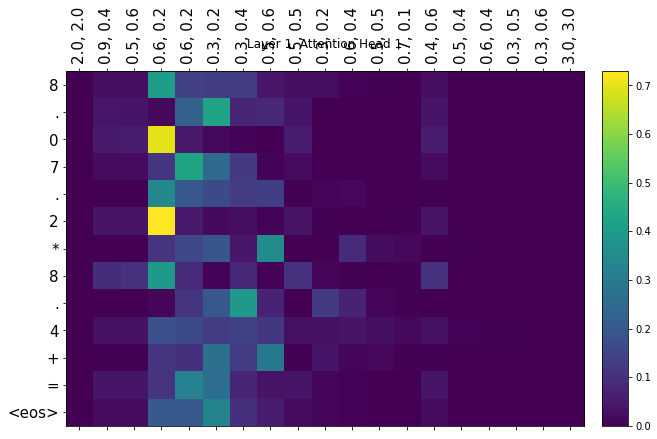

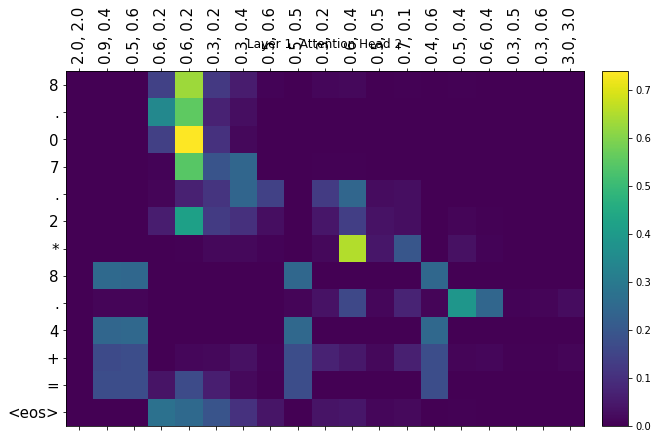

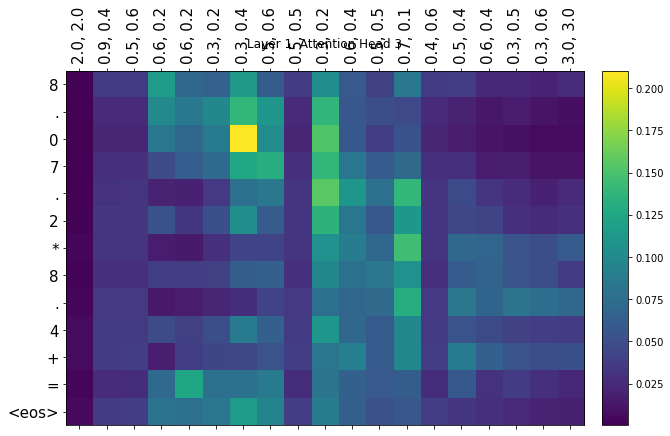

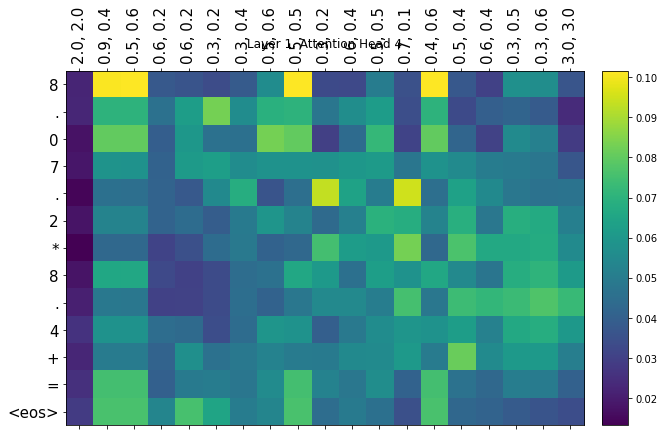

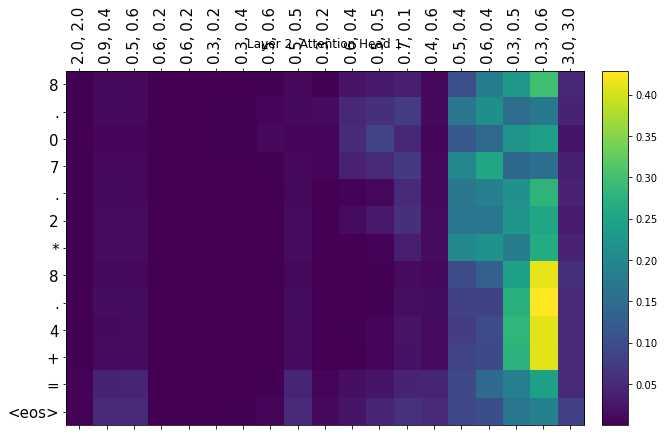

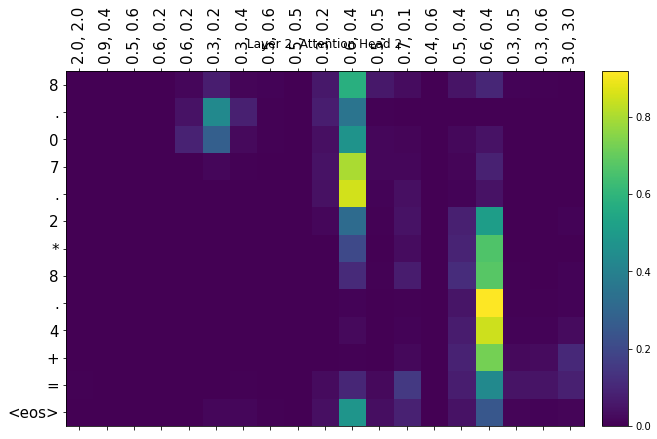

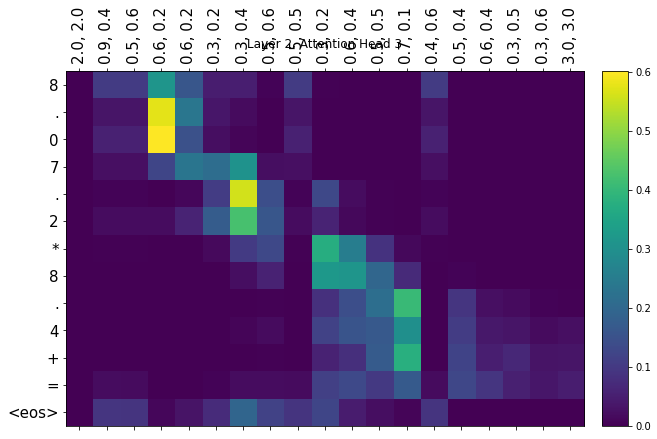

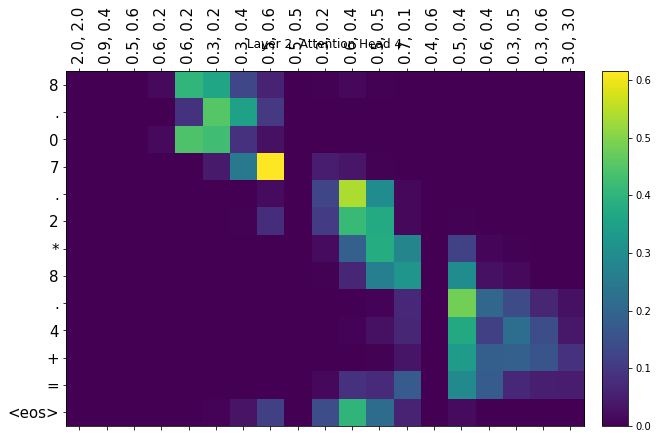

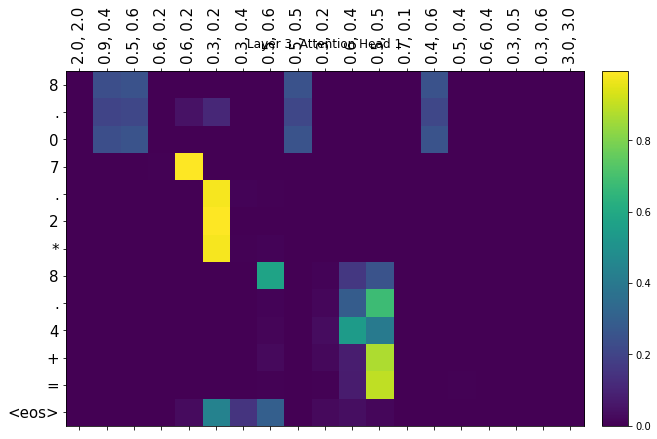

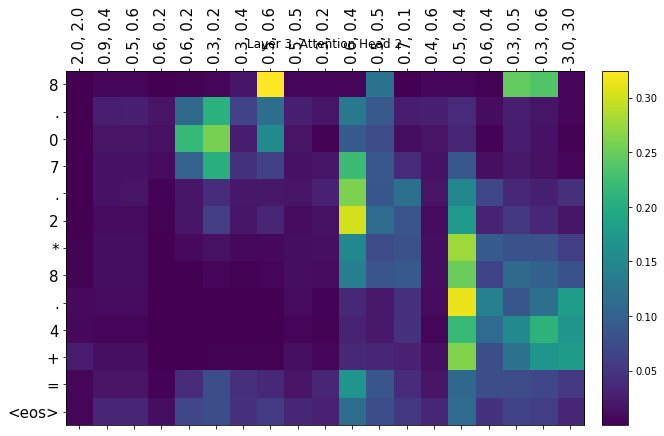

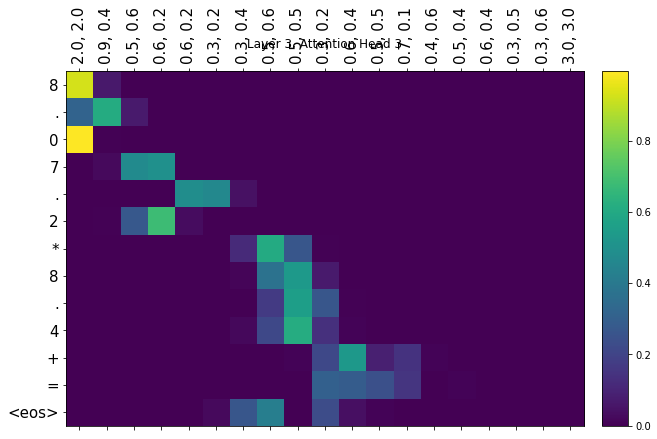

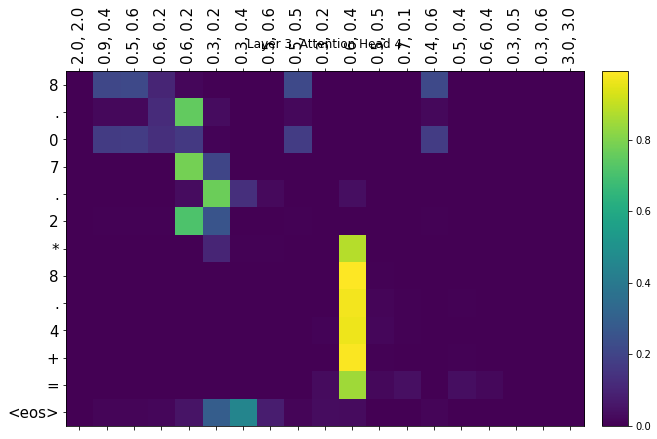

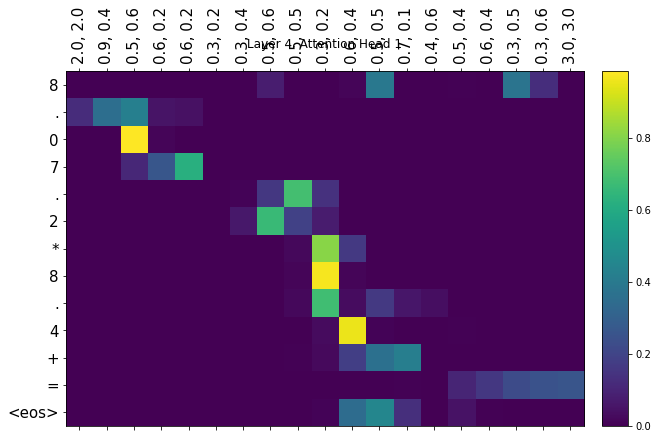

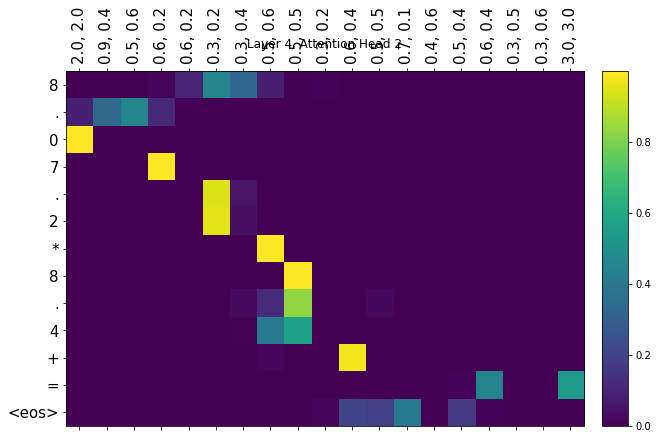

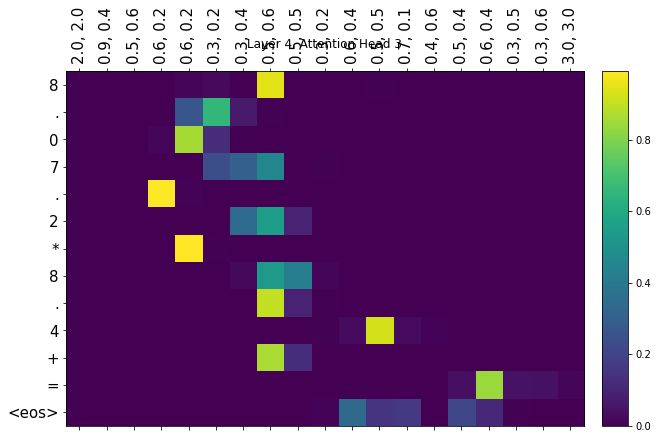

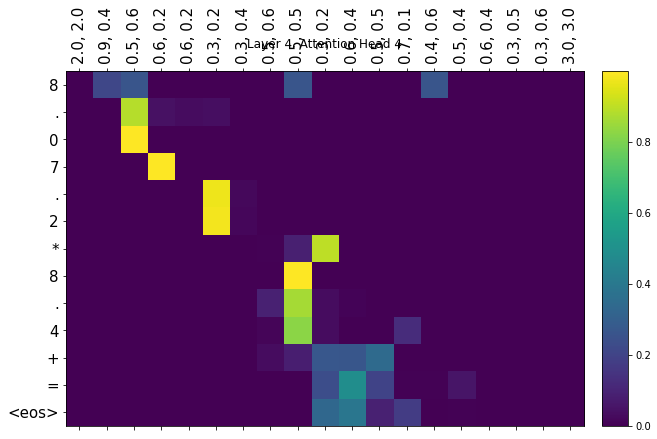

In [ ]:
print("Index:", ind)

test_set_iter = iter(test_set)
x_pred, y_pred = next(test_set_iter)

x_pred = x_pred.to(model.device)
y_pred = y_pred.to(model.device)

ind = random.choice(range(0, y_pred.shape[0]))
print("Index:", ind, "\n")


gt = tensor_to_word(y_pred[ind], VOCAB)
gt_list = [i for i in y_pred[ind].tolist() if i != 1]
gt_length = len([i for i in y_pred[ind] if i not in [PAD_IDX, BOS_IDX, EOS_IDX]])
prediction, attention = model.predict(x_pred[ind].unsqueeze(0))

print("Ground truth => ", gt_list , '\n')

# Show ground truth and prediction along with the lengths of the words/glyphs
print(f"Ground Truth: {''.join(gt)} (len={gt_length})")
print(f"- Prediction: {''.join(prediction)} (len={len(prediction)-2})")

end_index = d_gen.n_features
gt_expr = [", ".join(f"{j:.1f}" for j in i[0: end_index]) for i in x_pred[ind].tolist()]
translation = [i for i in prediction]

print("X axis => ", [i for i in gt])
print("Y axis => ", translation)

model.display_attention(gt_expr, translation, attention[0]) #cross-attention

In [ ]:
test_set_iter = iter(test_set)
avg_postfix_acc = model.evaluate_postfix_accuracy(test_set_iter)
print(f"\nMin and max accuracy of test set are: {avg_postfix_acc}")